In [1]:
import os
import gzip
import shutil
import requests

import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from keras import Sequential, metrics
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, Normalization, Conv1D, Dropout, MaxPool2D, MaxPooling1D, Flatten
from keras.models import Model

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from ctd import get_data
from ctd.utils import get_disease_hierarchy


In [2]:
VERBOSE=False
EPOCHS=25
TRAIN_SIZE=.75

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')
]

In [3]:
class DiseaseClassifier:
    def __init__(self, input_df, parent_disease, gene_count, show_plots, use_class_weights, oversample, classification='binary'):
        self.input_df = input_df
        self.parent_disease = parent_disease
        self.target_diseases = get_disease_hierarchy(self.parent_disease)
        self.gene_count = gene_count
        self.show_plots = show_plots
        self.stop_early = True
        self.use_class_weights = use_class_weights
        self.oversample = oversample
        self.classification = classification
        self.top_n_genes = self.get_genes()
        self.model_type = 'DNN'

        if self.use_class_weights and self.oversample:
            raise Exception('Need to either use classweights OR oversample')
    
    def get_genes(self):
        gene_df = pd.DataFrame(self.input_df.groupby(['InferenceGeneSymbol']).size()).reset_index()
        gene_df.columns = ['InferenceGeneSymbol','cnt']
        top_n_genes_df = gene_df.sort_values('cnt', ascending=False)[:self.gene_count]
        top_n_genes = top_n_genes_df['InferenceGeneSymbol'].unique()

        return top_n_genes
    
    def prep_training_data(self):
        
        gene_df = self.input_df.loc[self.input_df['DirectEvidence'].isnull()][['ChemicalName', 'DiseaseName', 'InferenceGeneSymbol', 'InferenceScore', 'DiseaseID']]

        gene_df = gene_df.loc[gene_df['InferenceGeneSymbol'].isin(self.top_n_genes)]

        evidence_df = self.input_df.loc[self.input_df['DirectEvidence'].notnull()][['ChemicalName', 'DiseaseName', 'DirectEvidence', 'DiseaseID']]
        merged_df = gene_df.merge(evidence_df, on=['ChemicalName', 'DiseaseName', 'DiseaseID'])

        dummy_df = pd.get_dummies(merged_df, prefix='', prefix_sep='',columns=['InferenceGeneSymbol'])
        gb_df = dummy_df.groupby(['DiseaseName', 'ChemicalName', 'DiseaseID']).agg({np.max}).reset_index()

        gb_df.columns = gb_df.columns.droplevel(1)

        gb_df['label'] = np.where(gb_df['DirectEvidence'] == 'marker/mechanism',
                                                   gb_df['InferenceScore'] * -1,
                                                   gb_df['InferenceScore'])
        
        return gb_df
    
    def plot_results(self, history, predicted_values, y_test, accuracy):

        ## to do, subclass categorical classifications.. override this method
        if self.classification == 'categorical':

            cm = confusion_matrix(y_test.argmax(axis=1), predicted_values.argmax(axis=1))

            labels = ['Not Relevant', 'Therapeutic', 'Negative']
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

            disp.plot(cmap=plt.cm.Blues) # xticks_rotation=45
            return 0

        auc_score = roc_auc_score(y_test, predicted_values) 
        
        if not self.show_plots:
            return auc_score
        
        # plot accuracy
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes[0][0].plot(history.history['accuracy'],label='accuracy')
        axes[0][0].plot(history.history['val_accuracy'],label='val_accuracy')
        axes[0][0].text(2, history.history['accuracy'][0] + .005, 'accuracy: {:.4f}'.format(accuracy))

        axes[0][0].legend()

        # plot loss
        axes[0][1].plot(history.history['loss'],label='loss')
        axes[0][1].plot(history.history['val_loss'],label='val_loss')
        axes[0][1].legend()
        fig.tight_layout()

        fpr, tpr, thresholds = roc_curve (y_test , predicted_values)

        # plot_roc_curve
        axes[1][0].plot(fpr,tpr)
        axes[1][0].text(0.7, 0.9, 'auc: {:.4f}'.format(auc_score))
        axes[1][0].axis([-.05,1.1,0,1.05]) 

        # plot confusion matrix
        cm = confusion_matrix(y_test, np.where(predicted_values > 0.5, 1, 0))

        labels = ["Non Target", "Target"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues, ax=axes[1][1]) # xticks_rotation=45

        return auc_score
    
    def get_class_weights(self, labels):
        """
        Determine the weights to assign to each class based on the distribution of classes 
        """

        classes = labels.unique()
        total_classes = len(classes)

        total = len(labels)

        cl_weight = {}
        for cl in classes:
            count_of_this_class = len([x for x in labels if x == cl]) # optimize this.. 
            cl_weight[cl] = (1 / count_of_this_class) * (total / total_classes)

        return cl_weight
    
    def get_model(self, input_shape, output_shape):
        model = Sequential()
        
        model.add(Dense(60, input_dim=input_shape, activation='relu'))
        model.add(Dense(6, input_dim=input_shape, activation='relu'))
        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss=self.classification + '_crossentropy', optimizer='adam', metrics=METRICS)
        return model
    
    def over_sample(self, X_train, y_train):
        if self.classification == 'categorical':
            raise Exception('over sampling not supported with categorical classifications')
        bool_train_labels = y_train != 0

        pos_features = X_train[bool_train_labels]
        neg_features = X_train[~bool_train_labels]

        pos_labels = y_train[bool_train_labels]
        neg_labels = y_train[~bool_train_labels]

        ids = np.arange(len(pos_features))
        choices = np.random.choice(ids, len(neg_features))

        res_pos_features = pos_features.iloc[choices, :]
        res_pos_labels = pos_labels.values[choices] # pos_labels.array(choices)

        res_pos_features.shape

        resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
        resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

        order = np.arange(len(resampled_labels))
        np.random.shuffle(order)
        resampled_features = resampled_features[order]
        resampled_labels = resampled_labels[order]

        return resampled_features, resampled_labels
        
    def train_model(self, train_df):

        gene_columns = train_df.columns.intersection(self.top_n_genes)
        shuffled_df = train_df.sample(frac=1)
        features, labels = shuffled_df[gene_columns], shuffled_df['binary_label']
        
        if self.classification == 'categorical':
            enc = OneHotEncoder()
            labels = enc.fit_transform(shuffled_df['categorical_label'].values[:, np.newaxis]).toarray()
        
        output_layer_num = labels.shape[1] if self.classification == 'categorical' else 1
        model = self.get_model(features.shape[1], output_layer_num)
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)
        
        if self.oversample:
            X_train, y_train = self.over_sample(X_train, y_train)
        
        callbacks = []
        if self.stop_early:
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))
        
        model_fit_kw = {
            'x': X_train,
            'y': y_train,
            'epochs':25,
            'validation_split':0.2,
            'callbacks':callbacks,
            'verbose':VERBOSE
        }
        if self.use_class_weights:
            label_column = self.classification + '_label'
            model_fit_kw['class_weight'] = self.get_class_weights(train_df[label_column])
        
        ## fit the model
        history = model.fit(**model_fit_kw)
        
        ## make predictions on the test set
        predicted_values = model.predict(X_test)

        model_metrics = model.evaluate(X_test, y_test, verbose=VERBOSE)
        model_keys = ['loss'] + [m.name for m in METRICS]
        metrics_info = dict(zip(model_keys, model_metrics))

        auc = self.plot_results(history, predicted_values, y_test, metrics_info.get('accuracy'))

        
        return history,model, auc, metrics_info

    def apply_category(self, row):
        if row.binary_label == 0:
            return 0 # 'Not Releveant'
        if row.DirectEvidence == 'marker/mechanism':
            return 1 # 'Negative'
        else:
            return 2 # 'Therapeutic'
    
    def set_label(self, train_df):

        train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(self.target_diseases),1, 0)

        if self.classification == 'categorical':
            train_df['categorical_label'] = train_df.apply(lambda row: self.apply_category(row), axis=1)

        return train_df
        
   
    def main(self):
        train_df = self.prep_training_data()
        train_df = self.set_label(train_df)
        history, model, auc, model_metrics =  self.train_model(train_df)

        model_metrics['parent_disease'] = self.parent_disease
        model_metrics['gene_count'] = self.gene_count
        model_metrics['show_plots'] = self.show_plots
        model_metrics['use_class_weights'] = self.use_class_weights
        model_metrics['oversample'] = self.oversample
        model_metrics['model_type'] = self.model_type
               
        return model_metrics, model

In [4]:
input_df = get_data('ChemicalDiseaseInteractions')

/opt/conda/lib/python3.11/site-packages/ctd/get_data.py:103: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(the_file, skiprows=29, names=header)


## DNN with class weights

418/418 [==============================] - 1s 3ms/step


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
0,0.133283,115.0,740.0,12489.0,23.0,0.942919,0.134503,0.833333,0.967876,0.630146,MESH:D019636,1000,True,True,False,DNN


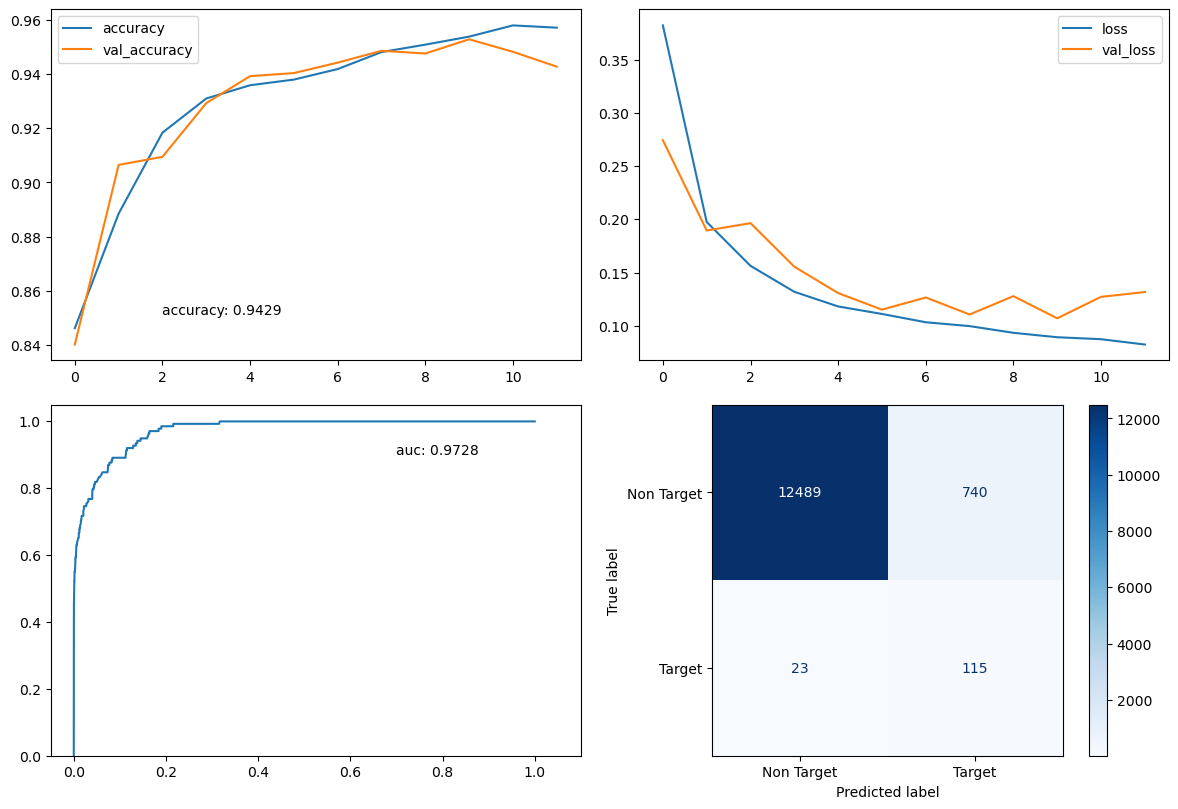

In [5]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False
}
dc = DiseaseClassifier(**kw)
dc_mm, _ = dc.main()
display(pd.DataFrame([dc_mm]))

## DNN with Oversampling

418/418 [==============================] - 1s 2ms/step


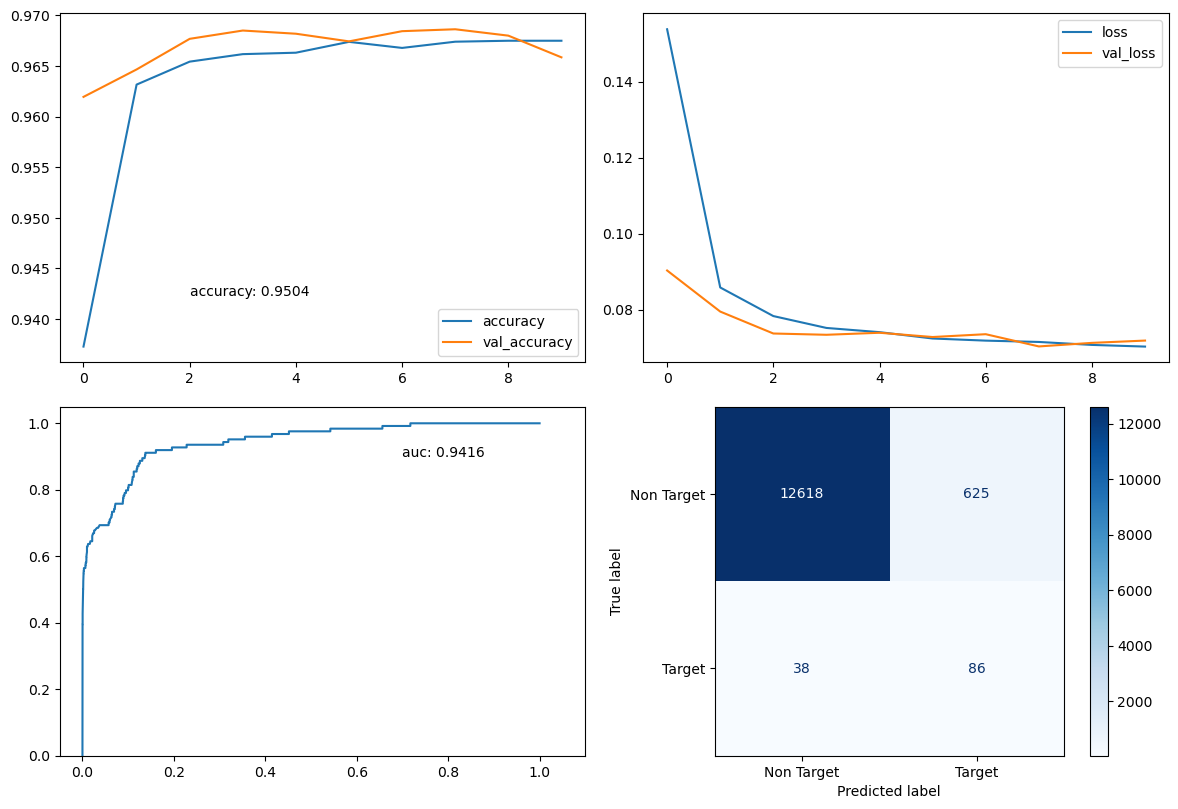

In [6]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'show_plots': True,
    'use_class_weights': False,
    'oversample': True
}
dnn_os = DiseaseClassifier(**kw)
mm = dnn_os.main()

## Iterate over a number of different permutations 

In [7]:
import time
import json
import datetime
from itertools import product

parent_disease = 'MESH:D019636'
permutations = []
for gene_count in range(25, 1025, 25):
    permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':True, 'use_class_weights': False})
    permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':False, 'use_class_weights': True})
    permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':False, 'use_class_weights': False})

results = []
for i, (p) in enumerate(permutations):
    p['input_df'] = input_df
    p['show_plots'] = False
    _m = DiseaseClassifier(**p)
    
    model_results, _ = _m.main()
    with open('out_stream.txt', 'a') as f:
        f.write(json.dumps(model_results) + '\n')
    results.append(model_results)

df = pd.DataFrame(results)

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df.to_csv('final-output/{ts}.csv'.format(ts=now))


418/418 [==============================] - 1s 3ms/step


## what are the best params to use?

,Unnamed: 0,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
22,22,0.236262,102.0,1643.0,10520.0,5.0,0.865689,0.058453,0.953271,0.977657,0.681726,MESH:D019636,200,False,True,False,DNN
13,13,0.239236,100.0,1410.0,10140.0,5.0,0.878593,0.066225,0.952381,0.973490,0.637868,MESH:D019636,125,False,True,False,DNN
37,37,0.183106,107.0,1101.0,11551.0,8.0,0.913135,0.088576,0.930435,0.979209,0.694739,MESH:D019636,325,False,True,False,DNN
76,76,0.248634,117.0,1769.0,11296.0,9.0,0.865211,0.062036,0.928571,0.968397,0.600828,MESH:D019636,650,False,True,False,DNN
16,16,0.232625,105.0,1293.0,10585.0,9.0,0.891428,0.075107,0.921053,0.967056,0.625190,MESH:D019636,150,False,True,False,DNN
58,58,0.164777,116.0,1031.0,11879.0,11.0,0.920074,0.101133,0.913386,0.975569,0.690196,MESH:D019636,500,False,True,False,DNN
19,19,0.185573,102.0,1084.0,10926.0,10.0,0.909751,0.086003,0.910714,0.980543,0.707492,MESH:D019636,175,False,True,False,DNN
10,10,0.230175,104.0,1621.0,9613.0,11.0,0.856199,0.060290,0.904348,0.967855,0.636261,MESH:D019636,100,False,True,False,DNN
70,70,0.162338,119.0,1076.0,11938.0,13.0,0.917161,0.099582,0.901515,0.976775,0.670409,MESH:D019636,600,False,True,False,DNN
28,28,0.184242,116.0,1230.0,11137.0,13.0,0.900528,0.086181,0.899225,0.971977,0.652587,MESH:D019636,250,False,True,False,DNN


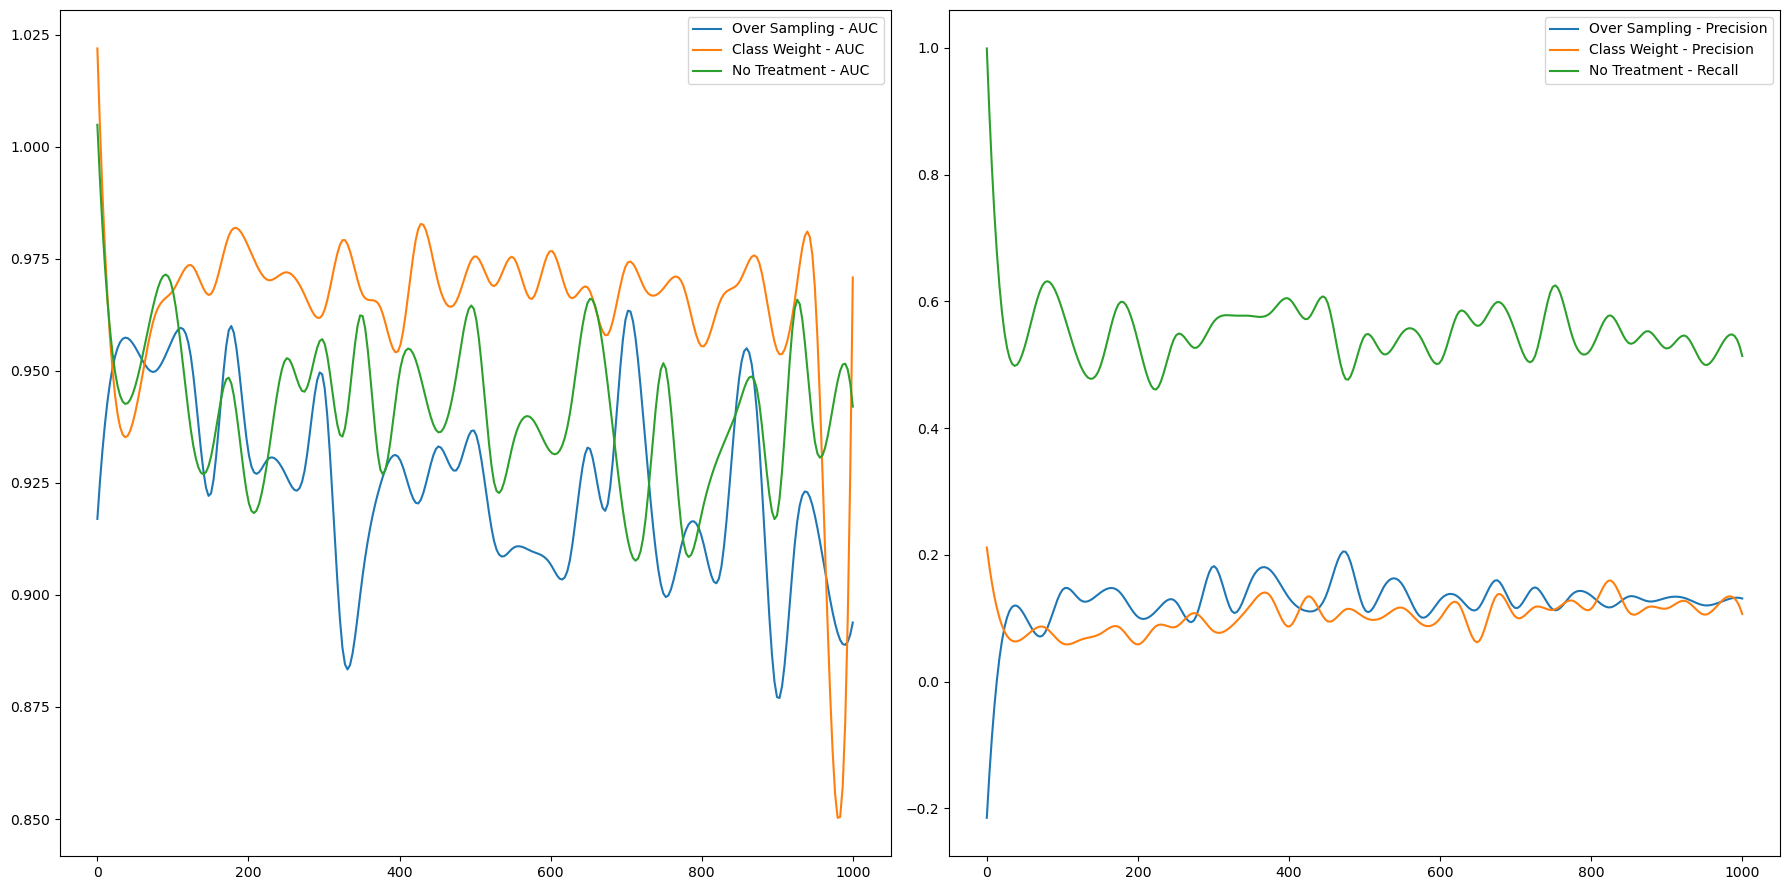

In [8]:
import pandas as pd
import glob

from scipy.interpolate import make_interp_spline, BSpline

csv_files = glob.glob('final-output/*.csv')
csv_files.sort(key=os.path.getmtime, reverse=True)
most_recent_file = csv_files[0]
results_df = pd.read_csv(most_recent_file)
# results_df = pd.read_csv('tmp_output.csv')

display(results_df.sort_values('recall', ascending=False)[:10])

def get_plot(df, metric):
    x_axis = df['gene_count']
    xnew = np.linspace(0, max(x_axis), 300) 
    spl = make_interp_spline(df['gene_count'], df[metric], k=3)
    power_smooth = spl(xnew)

    return xnew, power_smooth

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
dnn_df = results_df[(results_df['model_type'] == 'DNN')]

oversample_df = dnn_df[dnn_df['oversample']]
class_weight_df = dnn_df[dnn_df['use_class_weights']]
no_treatment_df = dnn_df[(dnn_df['oversample'] == False) & (dnn_df['use_class_weights'] == False)]

axes[0].plot(*get_plot(oversample_df, 'auc'), label='Over Sampling - AUC')
axes[0].plot(*get_plot(class_weight_df, 'auc'), label='Class Weight - AUC')
axes[0].plot(*get_plot(no_treatment_df, 'auc'), label='No Treatment - AUC')
axes[0].legend()

axes[1].plot(*get_plot(oversample_df, 'precision'), label='Over Sampling - Precision')
axes[1].plot(*get_plot(class_weight_df, 'precision'), label='Class Weight - Precision')
axes[1].plot(*get_plot(no_treatment_df, 'recall'), label='No Treatment - Recall')
axes[1].legend()


fig.tight_layout()

## DNN with Multi Class

227/227 [==============================] - 1s 3ms/step


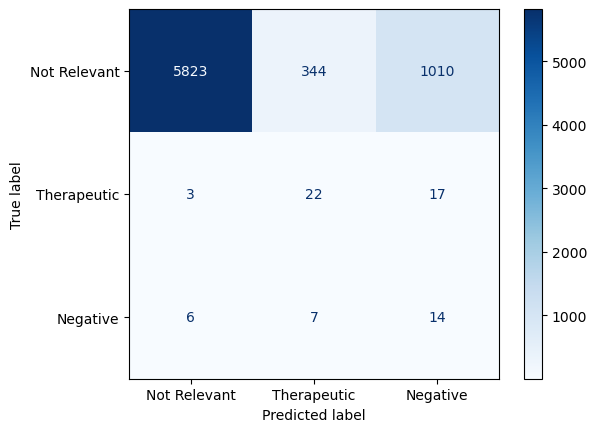

In [9]:
# do this
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 10,
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False,
    'classification': 'categorical'
}
cat = DiseaseClassifier(**kw)
mm, _ = cat.main()

### Here we evaluate the chemicals that have posibile therapeutic and harmful effects as it relates to.  We take the chemical to gene network.  I want to see chemicals *not* in the dataset that we can research.

418/418 [==============================] - 1s 2ms/step


512MB [00:06, 79.6MB/s]                             


NameError: name 'chem_cl' is not defined

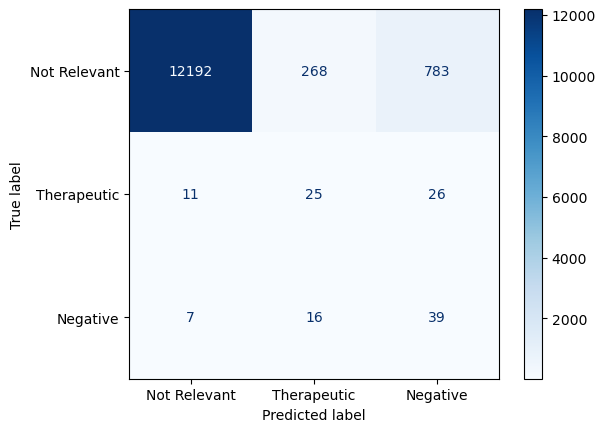

In [10]:
# instatiate the model to get the relevant genes that we need to process.. dont need to fit the model yet
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'show_plots': False,
    'oversample': False,
    'use_class_weights': True,
    'classification': 'categorical'
}
dc = DiseaseClassifier(**kw)
chem_cl_metrics, chem_cl_model = dc.main()

inp_df = get_data('ChemicalGeneInteractions')
inp_df = inp_df[inp_df['GeneSymbol'].isin(chem_cl.top_n_genes)]

## process the chemical -> dataset ( without disease ) in the same way we do our input data
gb_df = inp_df.groupby(['ChemicalName', 'GeneSymbol']).size().reset_index()
gb_df.columns = ['ChemicalName','GeneSymbol', 'InteractionCount']
dummy_df = pd.get_dummies(gb_df, prefix='', prefix_sep='',columns=['GeneSymbol'])

chem_df = dummy_df.groupby(['ChemicalName']).agg({np.max}).reset_index()
chem_df.columns = chem_df.columns.droplevel(1)

predicted_values = chem_cl_model.predict(chem_df[chem_cl.top_n_genes])

predicted_value_df = pd.DataFrame(predicted_values, columns=['Ther', 'Not Relevant', 'Marker'])

final = chem_df.merge(predicted_value_df, left_index=True, right_index=True)
final = final[['ChemicalName', 'Ther', 'Not Relevant', 'Marker']]

print('--- THER ---')
display(final.nlargest(5, 'Ther'))

print('--- MARKER ---')
display(final.nlargest(5, 'Marker'))

# chem_df[:4]

In [ ]:
## ctd says (+)-JQ1 compound	 is associated with the reduction of inflamation
## pub chem says trimethyllead is acutely toxic - https://pubchem.ncbi.nlm.nih.gov/compound/Trimethyllead-acetate is ""

## Understanding feature importance -- what genes are coorelated with Parkinsons / Neurodegenerative diseass

In [ ]:

from sklearn.ensemble import RandomForestClassifier


def feature_importance(features, labels, stop_early=True, show_plots=True):
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

    rand_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rand_forest_classifier.fit(X_train, y_train)

    optimal_node_count = 128
    feature_count = 70
    output_label_len = 10
    imp_arr = rand_forest_classifier.feature_importances_
    
    gene_importance = dict(zip(features.columns, imp_arr))
    gene_importance_df = pd.DataFrame({'gene': features.columns, 'score': imp_arr})

    return gene_importance_df.sort_values('score', ascending=False)

## Gene Importance for Neurodegenrative Diseases

In [ ]:
train_df = chem_cl.prep_training_data()
train_df = chem_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(chem_cl.top_n_genes)

print(len(gene_columns))
shuffled_df = train_df.sample(frac=1)

gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

gene_importance_df.hist()

ax = gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))

## Gene Importance for Parkinsons

In [ ]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D010300', # parkinsons diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': False,
    'oversample': True,
    'use_class_weights': False,
    'classification': 'binary'
}
park_cl = DiseaseClassifier(**kw)
results, park_model = park_cl.main()


train_df = park_cl.prep_training_data()
train_df = park_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(park_cl.top_n_genes)

shuffled_df = train_df.sample(frac=1)

park_gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

## https://www.nature.com/articles/ng0892-345 # APP shows up... has strong inference to alzheimers
ax = park_gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))
